In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import rfft,fft,fftfreq,rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import math
from itertools import combinations
from string import ascii_uppercase as abc; abc = abc
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from itertools import compress, product
import random
import warnings
import calendar

warnings.filterwarnings("ignore")


plt.rc('font', size=7) 
plt.rc('xtick', labelsize=7) 
plt.rc('ytick', labelsize=7) 
plt.rc('axes', titlesize=7) 
matplotlib.rcParams["figure.dpi"] = 100

def fit_cosinor(xdat,ydat):
    M      = np.mean(ydat)
    ydat   = ydat-M
    st     = np.std(ydat)
    maxamp = np.max(abs(ydat))
    # 1st order cosinor - 2 parameters: A,phi (normalized ydat to  mean = 0 in order to remove baseline fitting)
    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),xdat,ydat,p0=[st,0],bounds=[(maxamp/20,-np.pi),(maxamp*2,np.pi)])
    return np.array(list(res_fit) + [M])

months        = [x[:3] for x in calendar.month_name[1:13]]
raw_data      = pd.read_csv('age.GLUCOSE_BLOOD.healthy_no_meds.raw.with_infection.0.05.20_30_40_50_60_70_80.csv')
quantile_data = pd.read_csv('age.GLUCOSE_BLOOD.healthy_no_meds.quantile.with_infection.0.05.20_30_40_50_60_70_80.csv')
raw_splits    = np.array_split(raw_data, len(raw_data)/12)
qua_splits    = np.array_split(quantile_data, len(quantile_data)/12)

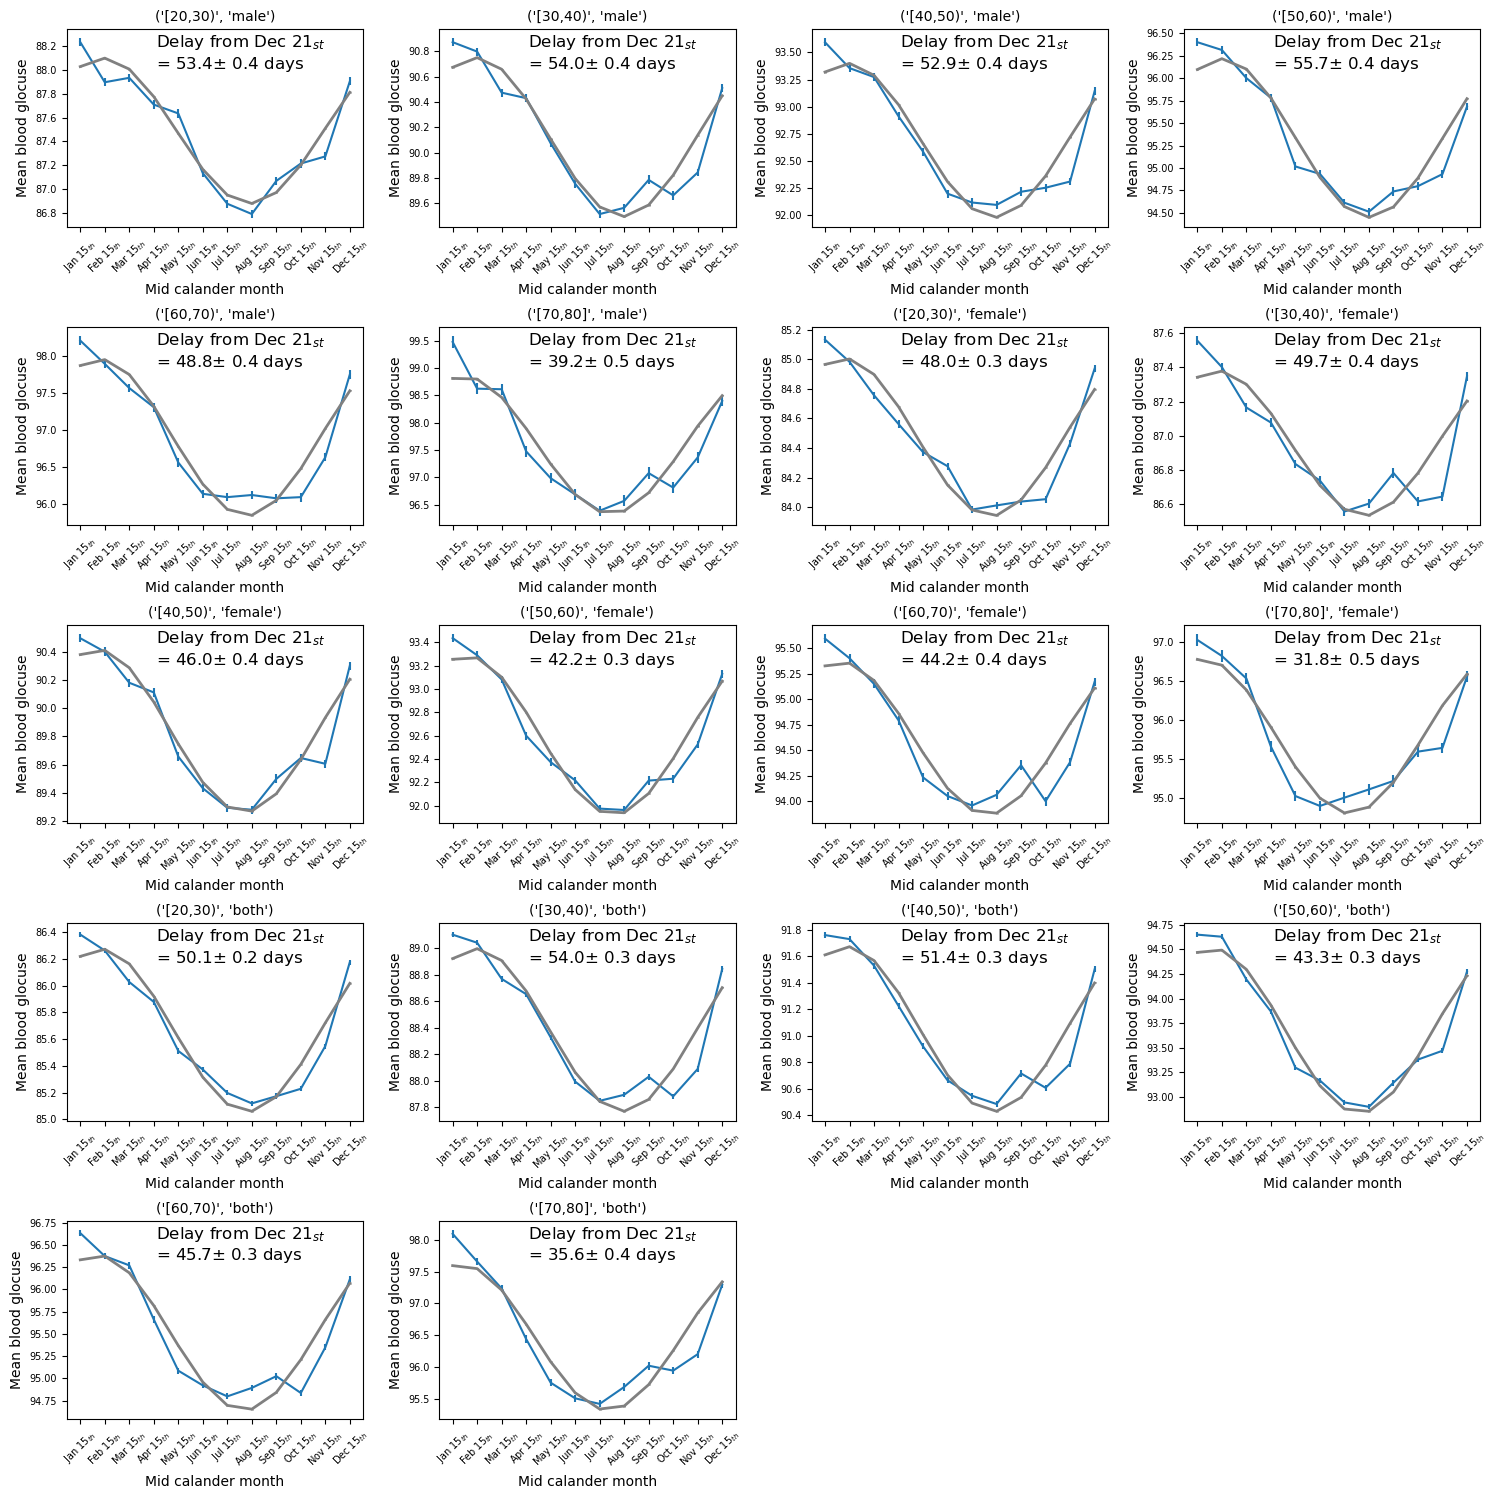

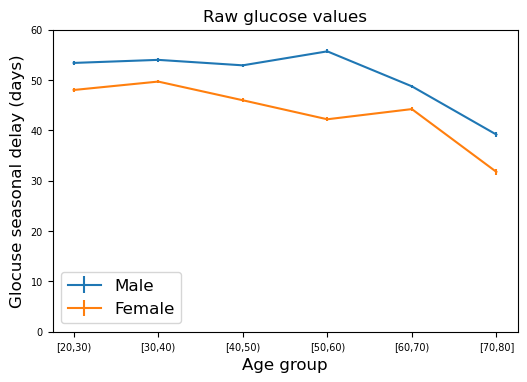

In [7]:
plt.figure(figsize=(15,15))
summery = []
for k,tdf in enumerate(raw_splits):
    group       = (tdf['age_group'].iloc[0],tdf['type'].iloc[0])
    tdf['serr'] = tdf['std']/np.sqrt(tdf['n'])
    ydat        = tdf['mean']
    yerr        = tdf['serr']

    # The first bin is centered around Jan 15th, thus its x value is 25 days after Dec 21st, in radians:
    xdat        = 2*np.pi*(np.arange(12)/12+25/365) 
    fit_pars    = fit_cosinor(xdat,ydat)
    y_pred      = fit_pars[0]*np.cos(xdat+fit_pars[1])+fit_pars[2]

    bs_group    = pd.DataFrame([fit_cosinor(xdat,tdf['mean'] + np.random.rand(12)*tdf['serr']) for bs in range(100)],columns=['A','phi','M'])
    y_bs_preds  = np.array([bs_group['A'].iloc[i]*np.cos(xdat+bs_group['phi'].iloc[i])+bs_group['M'].iloc[i] for i in range(len(bs_group))])

    ax = plt.subplot(5,4,1+k)
    ax.errorbar(tdf.month,ydat,yerr)
    ax.errorbar(tdf.month,np.mean(y_bs_preds,axis=0),np.std(y_bs_preds,axis=0),c='gray',lw=2)
    ax.set_ylabel('Mean blood glocuse',fontsize=10)
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels([m +' $15_{th}$' for m in months],rotation=45)
    ax.set_xlabel('Mid calander month',fontsize=10)
    ax.annotate('Delay from Dec $21_{st}$\n= ' + str(np.round(365*(-bs_group.phi.mean())/(2*np.pi),decimals=1)) +'$\pm$ ' +  str(np.round(365*(bs_group.phi.std())/(2*np.pi),decimals=1))  +' days',xycoords ='axes fraction',xy=(0.3,0.8),fontsize=12)
    ax.set_title(group,fontsize=10)

    summery.append(bs_group)
plt.tight_layout(); plt.show()

df = pd.DataFrame([[raw_splits[i]['age_group'].iloc[0],raw_splits[i]['type'].iloc[0],summery[i].phi.mean(),summery[i].phi.std()] for i in range(len(raw_splits))])
df.columns = ['age','sex','phi_rad','phi_rad_err']
df['phi_days']     = 365*(-df['phi_rad'])/(2*np.pi)
df['phi_days_err'] = 365*(df['phi_rad_err'])/(2*np.pi)

plt.errorbar(df.loc[df.sex=='male']['age'],df.loc[df.sex=='male']['phi_days'],df.loc[df.sex=='male']['phi_days_err'])
plt.errorbar(df.loc[df.sex=='female']['age'],df.loc[df.sex=='female']['phi_days'],df.loc[df.sex=='male']['phi_days_err'])
plt.xlabel('Age group',fontsize=12)
plt.ylabel('Glocuse seasonal delay (days)',fontsize=12)
plt.legend(['Male','Female'],fontsize=12)
plt.title('Raw glucose values',fontsize=12)
plt.ylim([0,60])
plt.show()

raw_df = df.copy()

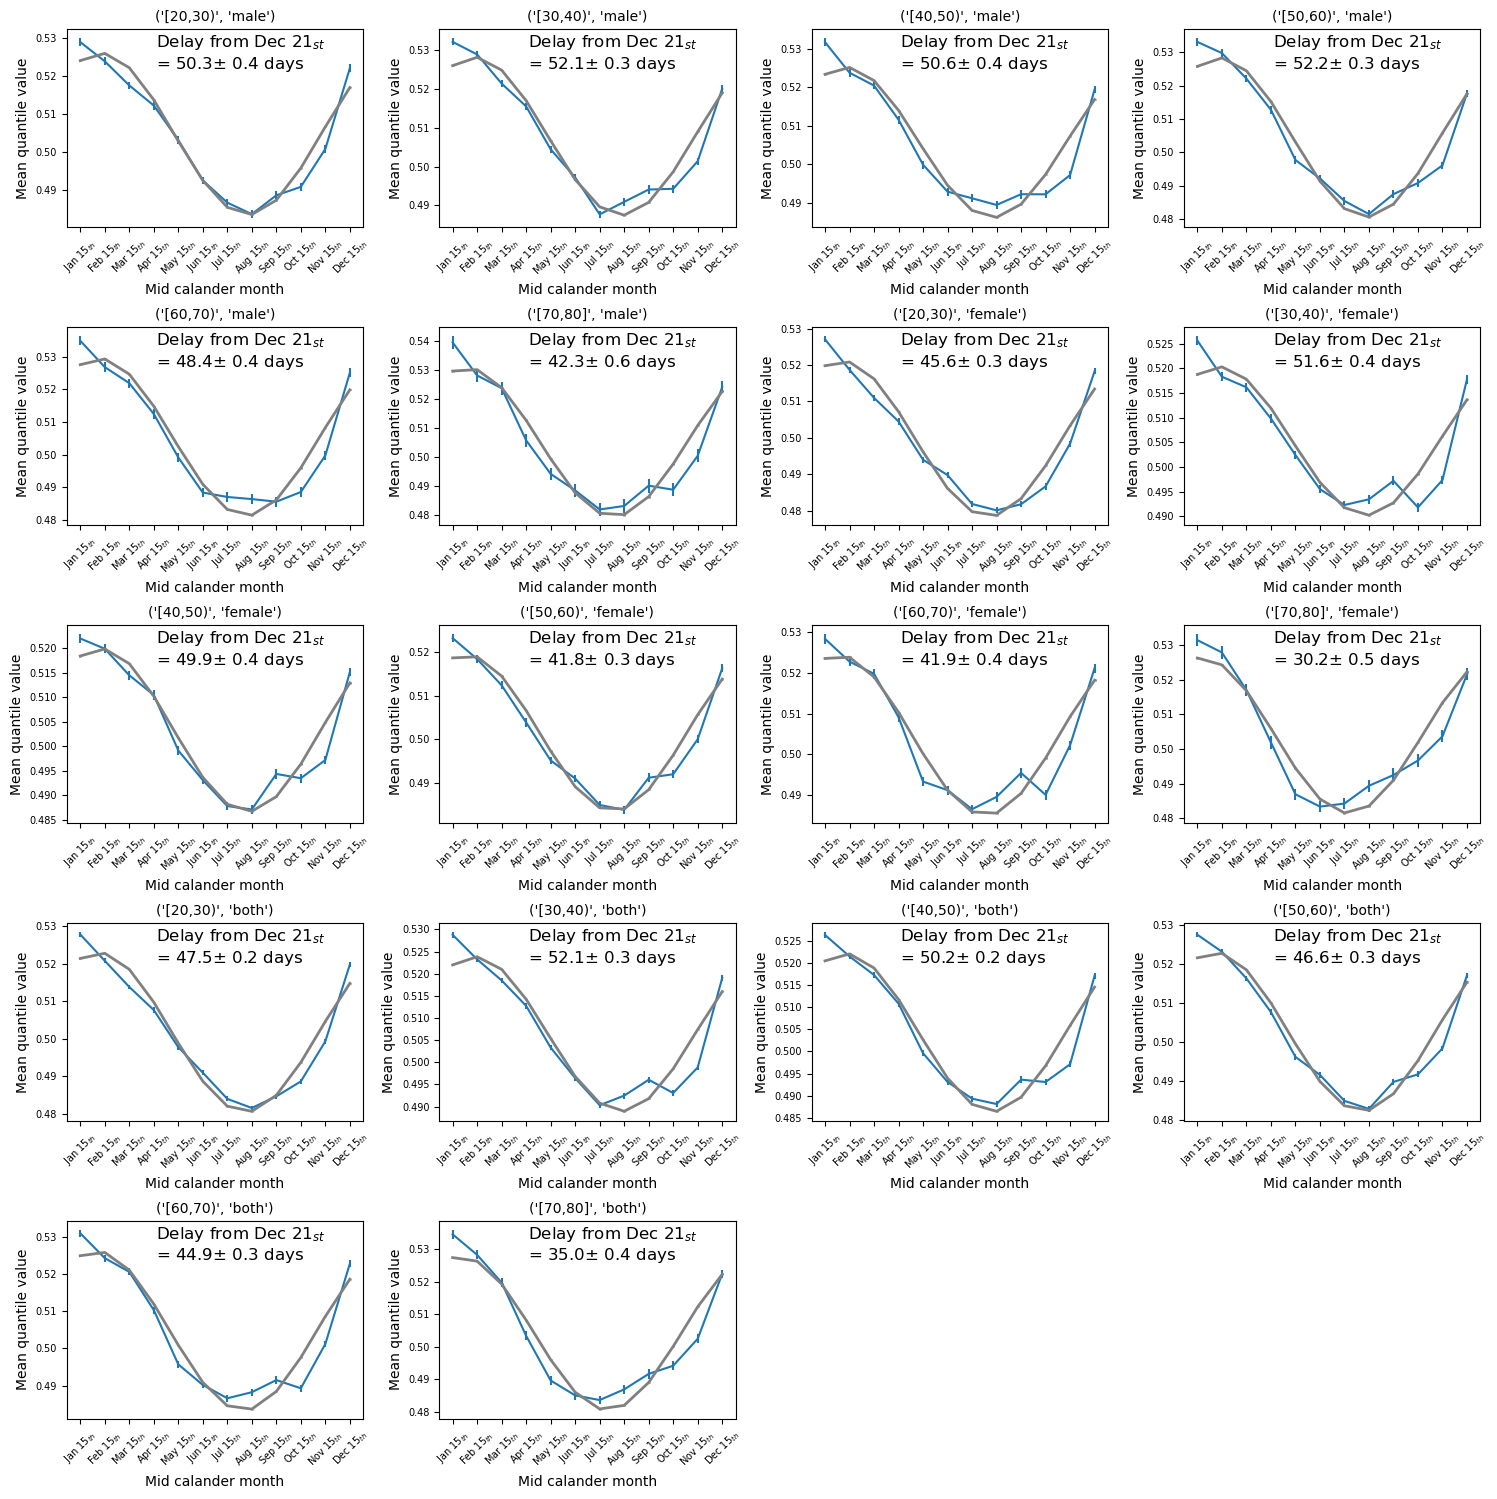

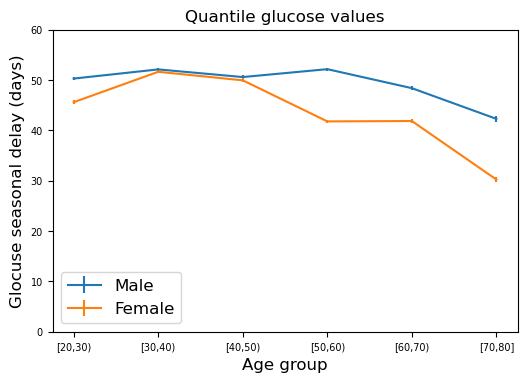

In [8]:
plt.figure(figsize=(15,15))
summery = []
for k,tdf in enumerate(qua_splits):
    group       = (tdf['age_group'].iloc[0],tdf['type'].iloc[0])
    tdf['serr'] = tdf['std']/np.sqrt(tdf['n'])
    ydat        = tdf['mean']
    yerr        = tdf['serr']

    # The first bin is centered around Jan 15th, thus its x value is 25 days after Dec 21st, in radians:
    xdat        = 2*np.pi*(np.arange(12)/12+25/365) 
    fit_pars    = fit_cosinor(xdat,ydat)
    y_pred      = fit_pars[0]*np.cos(xdat+fit_pars[1])+fit_pars[2]

    bs_group    = pd.DataFrame([fit_cosinor(xdat,tdf['mean'] + np.random.rand(12)*tdf['serr']) for bs in range(100)],columns=['A','phi','M'])
    y_bs_preds  = np.array([bs_group['A'].iloc[i]*np.cos(xdat+bs_group['phi'].iloc[i])+bs_group['M'].iloc[i] for i in range(len(bs_group))])

    ax = plt.subplot(5,4,1+k)
    ax.errorbar(tdf.month,ydat,yerr)
    ax.errorbar(tdf.month,np.mean(y_bs_preds,axis=0),np.std(y_bs_preds,axis=0),c='gray',lw=2)
    ax.set_ylabel('Mean quantile value',fontsize=10)
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels([m +' $15_{th}$' for m in months],rotation=45)
    ax.set_xlabel('Mid calander month',fontsize=10)
    ax.annotate('Delay from Dec $21_{st}$\n= ' + str(np.round(365*(-bs_group.phi.mean())/(2*np.pi),decimals=1)) +'$\pm$ ' +  str(np.round(365*(bs_group.phi.std())/(2*np.pi),decimals=1))  +' days',xycoords ='axes fraction',xy=(0.3,0.8),fontsize=12)
    ax.set_title(group,fontsize=10)

    summery.append(bs_group)
plt.tight_layout(); plt.show()

df = pd.DataFrame([[qua_splits[i]['age_group'].iloc[0],qua_splits[i]['type'].iloc[0],summery[i].phi.mean(),summery[i].phi.std()] for i in range(len(qua_splits))])
df.columns = ['age','sex','phi_rad','phi_rad_err']
df['phi_days']     = 365*(-df['phi_rad'])/(2*np.pi)
df['phi_days_err'] = 365*(df['phi_rad_err'])/(2*np.pi)

plt.errorbar(df.loc[df.sex=='male']['age'],df.loc[df.sex=='male']['phi_days'],df.loc[df.sex=='male']['phi_days_err'])
plt.errorbar(df.loc[df.sex=='female']['age'],df.loc[df.sex=='female']['phi_days'],df.loc[df.sex=='male']['phi_days_err'])
plt.xlabel('Age group',fontsize=12)
plt.ylabel('Glocuse seasonal delay (days)',fontsize=12)
plt.legend(['Male','Female'],fontsize=12)
plt.title('Quantile glucose values',fontsize=12)
plt.ylim([0,60])
plt.show()

qua_df = df.copy()

In [6]:
qua_df.to_excel('glucose_seasonal_delay_quantile.xlsx')
raw_df.to_excel('glucose_seasonal_delay_raw.xlsx')